# Recolhendo os dados

## Importações

Importando biblioteca tweepy, por onde será acessada a API do Twitter. Também importando as biblioteca pandas e re, responsáveis por tratar e armazenar as informações coletadas do Twitter.

In [2]:
import re
import tweepy as tw
import pandas as pd

# Pacote com dicionário com chaves do twitter
import utils

## Acessando API do Twitter

Lendo arquivo .txt com as chaves para acessar a API do Twitter e em seguida acessando a API.

In [3]:
with open('twitter-tokens.txt','r') as tfile:
    consumer_key = tfile.readline().strip('\n')
    consumer_secret = tfile.readline().strip('\n')
    access_token = tfile.readline().strip('\n')
    access_token_secret = tfile.readline().strip('\n')

In [4]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth)

## Recuperando os Tweets

Definindo os termos de buscas, idioma e quantidade dos tweets recuperados assim como filtrando para não recuperar retweets.

In [5]:
query_search = 'covid' + '-filter:retweets'

cursor_tweets = tw.Cursor(api.search,
                  q=query_search,
                  lang='pt',tweet_mode='extended').items(100)

Recuperando o dicionário previamente criado com o as informações que serão recolhidas dos tweets recuperados.

In [6]:
tweets_dict = utils.tw_dict.copy()
tweets_dict

{'created_at': [],
 'id': [],
 'id_str': [],
 'full_text': [],
 'entities': [],
 'source': [],
 'user': [],
 'lang': []}

Recuperando os tweets através do cursor criado anteriormente e salvando-as no dicionário.

In [7]:
for tweet in cursor_tweets:
    for key in tweets_dict.keys():
        try:
            # para cada tweet recuperado tenta salva-lo no dicíonario em sua respectiva chave
            tw_from_key = tweet._json[key]
            # usa expressão regular para remover links dos tweets
            if key == 'full_text':
                tw_from_key = re.sub(r"http\S+", "", tw_from_key)
            tweets_dict[key].append(tw_from_key)
        except KeyError:
            # caso algum tweet recuperado não tenha algum dos dados procurados adiciona uma string vazia
            tw_from_key = ''
            tweets_dict[key].append('')        

Salvando os dados do dicionário em um dataframe.

In [8]:
tw_df = pd.DataFrame.from_dict(tweets_dict)
tw_df.head()

,created_at,id,id_str,full_text,entities,source,user,lang
0,Mon Sep 07 15:46:48 +0000 2020,1302996750882476037,1302996750882476037,@BrunnoMeloCBN Vergonhoso é político ROUBAR di...,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...","{'id': 350242543, 'id_str': '350242543', 'name...",pt
1,Mon Sep 07 15:46:47 +0000 2020,1302996748017823745,1302996748017823745,@VEJA Covid-19 faça seu trabalho.\n\nPS. algun...,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...","{'id': 4618269515, 'id_str': '4618269515', 'na...",pt
2,Mon Sep 07 15:46:42 +0000 2020,1302996725423124482,1302996725423124482,@GloboNews Não dá para argumentar que o pessoa...,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...","{'id': 105591215, 'id_str': '105591215', 'name...",pt
3,Mon Sep 07 15:46:42 +0000 2020,1302996725196611584,1302996725196611584,"Jornalista esportivo, João Bosco Tureta morre ...","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...","{'id': 106920001, 'id_str': '106920001', 'name...",pt
4,Mon Sep 07 15:46:32 +0000 2020,1302996681592655873,1302996681592655873,"É isso! ninguém morre de tiro, morre de trauma...","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...","{'id': 319196766, 'id_str': '319196766', 'name...",pt


# Visualizando os dados

## Importações

Importando algumas bibliotecas que ajudarão na visualização dos dados.

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

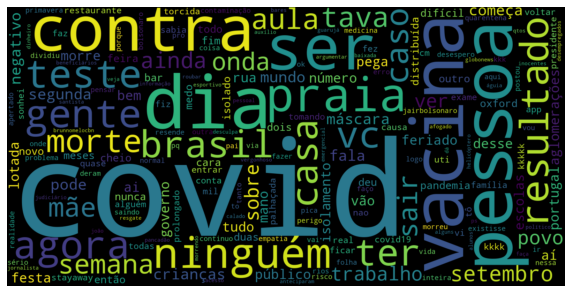

In [10]:
# Concatenando todas as letras em uma única string.
all_summary = " ".join(s for s in list(tw_df['full_text']))

# Criando lista de stopwords e adicionando algumas palavras à ela.
stopwords_pt = stopwords.words('portuguese')
stopwords_pt.extend(['pra','tá','https'])

# Gerando uma wordcloud.
wordcloud = WordCloud(stopwords=stopwords_pt, background_color="black", 
                      width=1600, height=800, collocations=False).generate(all_summary.lower())

# Mostrando a imagem final.
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

#### Carregando Modelo

Usando a biblioteca pickle para carregar o modelo salvo e carregando a função Preprocessing.

In [11]:
import pickle

In [12]:
# Carrega os modelos salvos
filename_modelo = 'modelo_class.sav'
modelo = pickle.load(open(filename_modelo, 'rb'))

filename_vectorizer = 'vectorizer.sav'
vectorizer = pickle.load(open(filename_vectorizer, 'rb'))

# Carrega função Preprocessing
Preprocessing = utils.Preprocessing

#### Usando modelo para classificar os tweets

In [14]:
teste_tweets = [Preprocessing(i) for i in tw_df.full_text]
freq_teste_tweets = vectorizer.transform(teste_tweets)

resultados = modelo.predict(freq_teste_tweets)

Criando coluna com a classificação do modelo.

In [15]:
tw_df['classe'] = resultados
tw_df[['full_text','classe']].head()

,full_text,classe
0,@BrunnoMeloCBN Vergonhoso é político ROUBAR di...,1
1,@VEJA Covid-19 faça seu trabalho.\n\nPS. algun...,2
2,@GloboNews Não dá para argumentar que o pessoa...,1
3,"Jornalista esportivo, João Bosco Tureta morre ...",2
4,"É isso! ninguém morre de tiro, morre de trauma...",2


Separando tweets classificados como negativos e outros.

In [16]:
tw_df_classe_1 = tw_df.query('classe==1')['full_text']
tw_df_classe_2 = tw_df.query('classe!=1')['full_text']

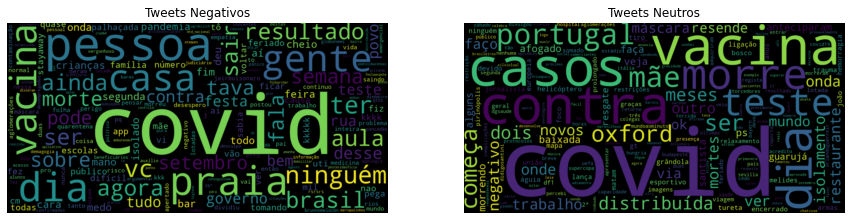

In [17]:
# Concatenando todas as letras em uma única string.
palavras_classe_1 = " ".join(s for s in list(tw_df_classe_1))
palavras_classe_2 = " ".join(s for s in list(tw_df_classe_2))

# Criando lista de stopwords e adicionando algumas palavras à ela.
stopwords_pt = stopwords.words('portuguese')
stopwords_pt.extend(['pra','tá','https'])

# Gerando wordclouds.
wordcloud_classe_1 = WordCloud(stopwords=stopwords_pt, background_color="black", 
                      width=1600, height=800, collocations=False).generate(palavras_classe_1.lower())
wordcloud_classe_2 = WordCloud(stopwords=stopwords_pt, background_color="black", 
                      width=1600, height=800, collocations=False).generate(palavras_classe_2.lower())

# Mostrando a imagem final.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))
axes[0].imshow(wordcloud_classe_1, interpolation='bilinear')
axes[0].set_title('Tweets Negativos')
axes[0].set_axis_off()
axes[1].imshow(wordcloud_classe_2, interpolation='bilinear')
axes[1].set_title('Tweets Neutros')
axes[1].set_axis_off()